# Class Data fMRI Analysis Tutorial

In this tutorial, we will provide a breif explanantion of the different "spaces" in which you can analyze and visualize brain data and walk you through how to fit a glm to data from multiple runs of an experiment in multiple participants. We will also show some additional examples of how to analyze funtional data that weren't covered in the fMRI Analysis tutorial.

By the end of this tutorial, you should have a clear understanding of the differente spaces of brain data and how to work with the data we collect in class for your final project.


# Overview of Brian Spaces

There are two main types of brain spaces we will cover in this class - **volumetric** and **surface**. 
- **Volumetric space** is a 3 demensional space that you have seen us work in in previous tutorials. This provide you with views of slices of the brain in x, y, and z coordinates. This is the space in what the MRI data are collected.
- **Surface space** takes the raw data from the scanner and "projects" it into a 2 demensional mesh. In surface space, instead of coordinates, you use what we call vertices. 

Within both volumetric and surface space there are two additional spaces of data - **native** and **average**. 
- **Native space** preserves individual anatomical details and variations such as the size, shape, and unique gyri and sucli patterns of their brain. This space is useful for individual analyses where preserving personal anatomical distinctions is critical, such as in studies of functional regions that vary across people or in longitudinal studies where changes within the same person are tracked over time.
- **Average space** (also referred to as standard or template space) is created by averaging anatomical data from many individuals. This space allows for consistency across participants by aligning each person's brain to a common reference. iIt facilitates group-level analyses and comparisons by aligning each brain to the same spatial coordinates, which is useful when making generalizations across groups or examining population-level patterns.

## Using ***your*** data to visualize these spaces

To get started, lets make sure you know how to access your data. Once we collect your data, I will do some data pre-processing and upload the pre-processed data to our [Google Drive folder](https://drive.google.com/drive/folders/1W_dSKaHSQua5-5cNoRm1VqPpNodMIUno?usp=sharing). Make sure you're logged in to your Stanford account to access the folder contents. Check the [Scan Tracker](https://docs.google.com/spreadsheets/d/1RcKL0vVLzOrzRPKqqD8jeccddN9ktu2Z4PKtX-v2yyI/edit?gid=0#gid=0) sheet to know the status of your data and to determine what your subject ID is for your data. These dataset are large so if you don't want to take up too much space on your computer, you can choose a brain space you want to work with and only download the files relevant to that space. Don't worry, I'll walk you through exactly what files you'll want to use for each space.

**Before you get scared looking at all the data**\
Looking at all the files in these folders can be overwhelming. Let's break down the parts of the file strings you'll be seeing in these data so you know what you're looking for:
- **sub**: For this tutorial, I will be using **sub-3** data from Emma's & Nika's experiment.
- **ses**: This refers to the session of data and because most groups will only collect data in each participant once you should expect to see everyone with just a **ses-1**
- **task**: For most scans, I will name your task **task-bold**. In cases where one participant completes multiple groups experiments, I will create unique names for the task. To make sure you know what your task is supposed to be, check the *Data name* column on the [Scan Tracker](https://docs.google.com/spreadsheets/d/1RcKL0vVLzOrzRPKqqD8jeccddN9ktu2Z4PKtX-v2yyI/edit?gid=0#gid=0).
- **run**: This tells you which run number of the experiment your looking at. If you only ran your experiment once, you'll only have **run-1**. If you ran it more than once you'll have multiple run numbers.
- **anat**: These folders indicate you're looking at anatomical data only.
- **func**: These folders indicate you're looking at functional data only.
- **fmriprep**: This is the software used to do the majority of preprocessing. This cleans that data and makes sure that all the data is properly aligned. Most of the data you'll need will come from this folder.
- **freesurfer**: This is the software that is used to project data from raw volumetric space to surface space. This folder only contains anatomical data in the surface spaces. Functional data will still be located in the fmriprep folder (in the func folder).

In [1]:
# I like to add all my import statements at the top of my notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json # for reading the tr
import glob # for creating lists of files
import nibabel as nib # for reading in your brain data
from nilearn import plotting # for vizualizing brain data
from nilearn import surface
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import datasets
from nilearn import signal

In [2]:
# set your base directory (this is the folder where you downloaded the data)
base_dir = '/Users/jamiel12/Downloads/EDUC 464 Fall 2024 Scan Data/'

# set some variables relevant to your data
sub = 'sub-3'
ses = 'ses-1'
task = 'bold'

### Native T1w 

We will be referring to the volumetric native space as **"Native T1"** in this class. 
Let's visualize it below.

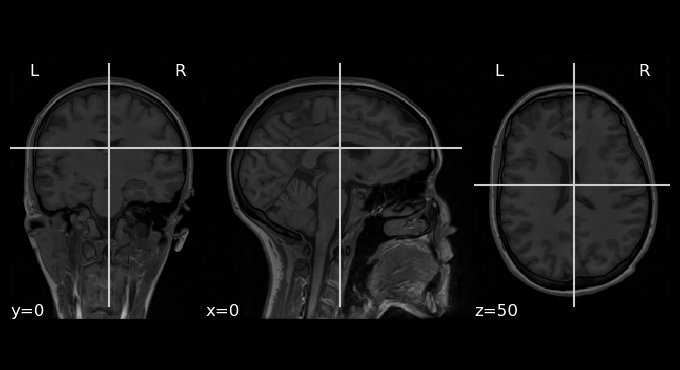

In [3]:
# load your image
## we suggest using "desc-preproc" but you can choose other options if you want ##
native_t1_path = f'{base_dir}fmriprep/{sub}/{ses}/anat/{sub}_{ses}_desc-preproc_T1w.nii.gz' 
native_t1 = nib.load(native_t1_path)

plotting.plot_anat(native_t1, cut_coords=(0,0,50))

### Average T1w

We will be referring to the volumetric average space as **"MNI"** in this class. The first MNI template was created and named after the Montreal Neurological Institute. The original template , MNI305, was created by averaging 305 human brains together. The standard template that is used today, MNI152, was created by the  International Consortium of Brain Mapping (ICBM) and is comprised of the average of 152 human brain scans that were registered to MNI305.

Let's visualize it below. 

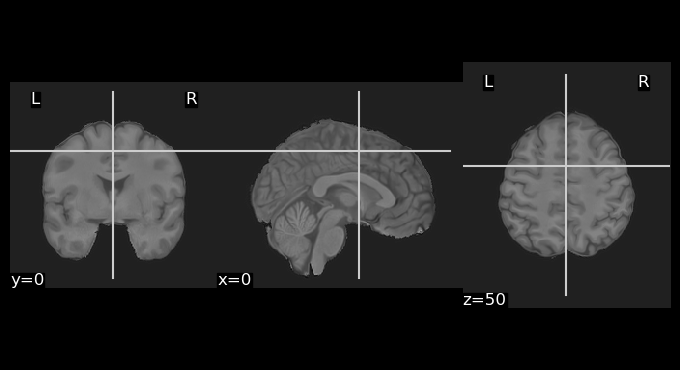

In [4]:
# load your image
## once again, we use "desc-preproc" but you can choose other options if you want ##
mni_t1_path = f'{base_dir}fmriprep/{sub}/{ses}/anat/{sub}_{ses}_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz' 
mni_t1 = nib.load(mni_t1_path)

plotting.plot_anat(mni_t1, cut_coords=(0,0,50))

Notice that this template only visualizes the brain because that was the only part of the 152 images that was averaged. This was done by first masking the image to only include the brain.

/Users/jamiel12/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



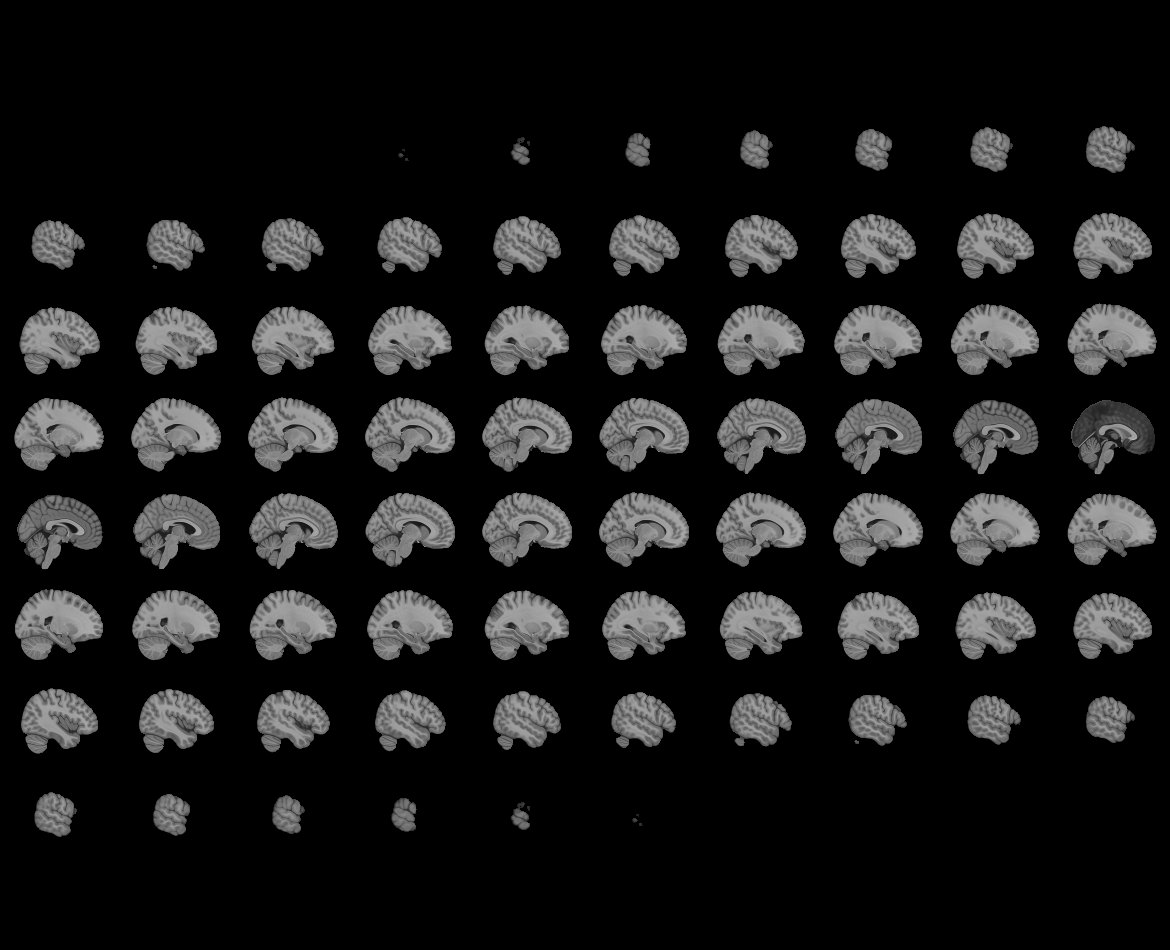
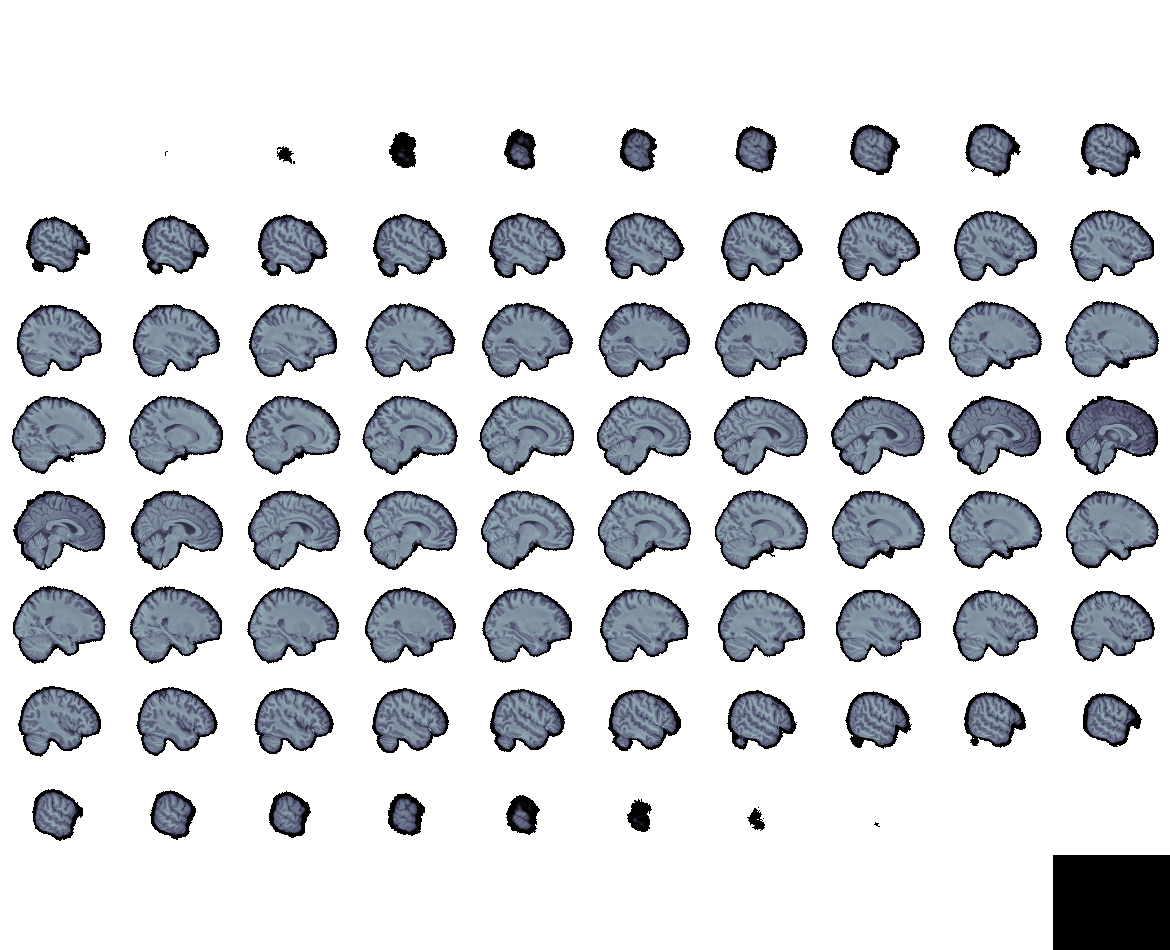

In [5]:
# plot an interactive MNI brain
plotting.view_img(mni_t1,cmap='brown_blue')

### Native Surface

We will be referring to the surface native space as **"fsnative"** in this class. "fs" stands for FreeSurfer which is the software that projeccts volumetric data to the surface. There are 2 ways to access the fsnative surfaces - in the freesurfer/surf folder and in the fmriprep/anat folder. I list the paths for both bellow however I suggest you stick to using the surface paths listed in the freesurfer folder.


In [6]:
# Load in the fsnative anatomical images - I suggest using these
fsnative_lh = surface.load_surf_mesh(f'{base_dir}freesurfer/{sub}/surf/lh.pial')
fsnative_rh = surface.load_surf_mesh(f'{base_dir}freesurfer/{sub}/surf/rh.pial')

# # Alternative options - these will have different dimensions than the freesurfer folder
# fsnative_lh = surface.load_surf_mesh(f'{base_dir}fmriprep/{sub}/{ses}/anat/{sub}_{ses}_hemi-L_pial.surf.gii')
# fsnative_rh = surface.load_surf_mesh(f'{base_dir}fmriprep/{sub}/{ses}/anat/{sub}_{ses}_hemi-R_pial.surf.gii')


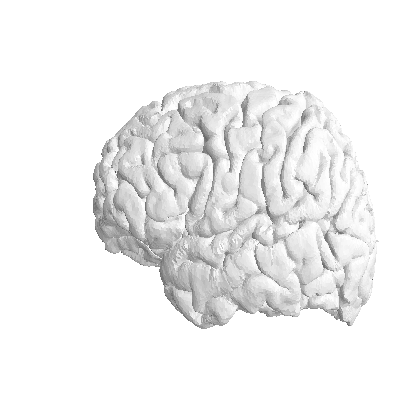

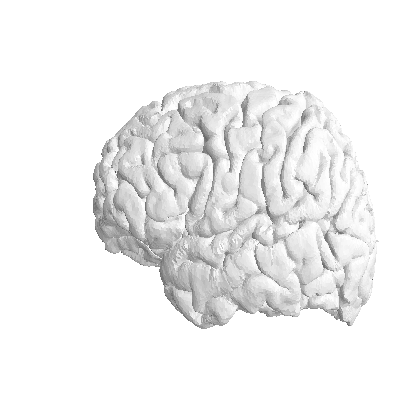

In [7]:
plotting.plot_surf(fsnative_lh,hemi='left')

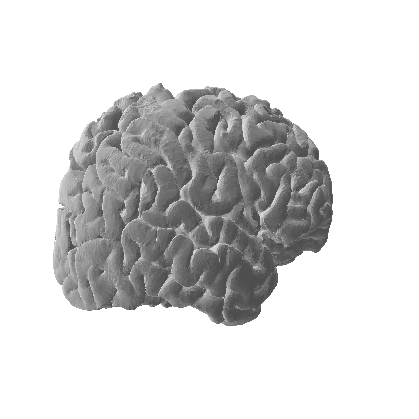

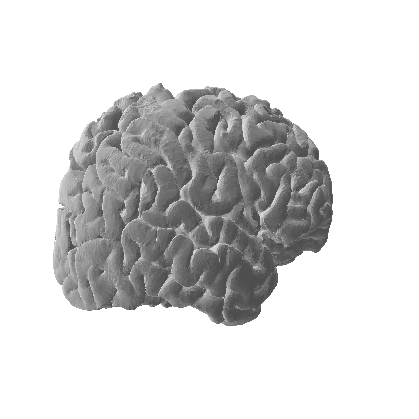

In [8]:
plotting.plot_surf(fsnative_rh,hemi='right')

### Average Surface

We will be referring to the surface native space as **"fsAverage"** in this class. One again, there are 2 ways to access the fsaverage surfaces - in the freesurfer/surf folder or through `nilearn.datasets.fetch_surf_fsaverage()`. I list the paths for both bellow however I suggest you stick to using the `fetch_surf_fsaverage` option this time for easily incorporating tutorial code.

In [9]:
# Load in the fsaverage anatomical images - Isuggest using this
fsaverage = datasets.fetch_surf_fsaverage()

fsaverage_lh = surface.load_surf_mesh(fsaverage['pial_left'])
fsaverage_rh = surface.load_surf_mesh(fsaverage['pial_right'])

# # Alternative options - these will have different dimensions than the `fetch_surf_fsaverage` option because it uses a different version of the template
# fsaverage_lh = surface.load_surf_mesh(f'{base_dir}freesurfer/fsaverage/surf/lh.inflated')
# fsaverage_rh = surface.load_surf_mesh(f'{base_dir}freesurfer/fsaverage/surf/rh.inflated')

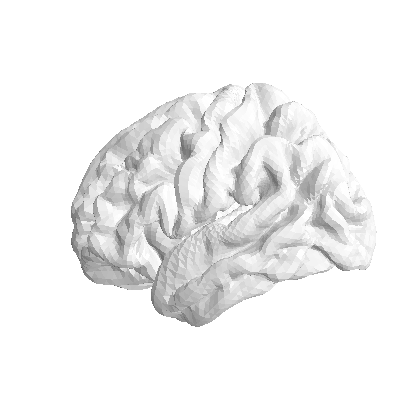

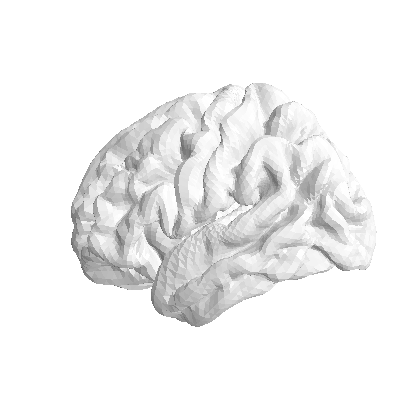

In [10]:
plotting.plot_surf(fsaverage_lh,hemi='left')

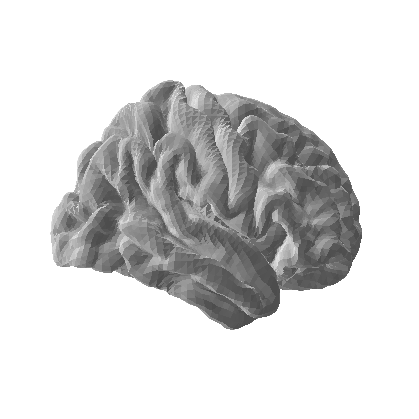

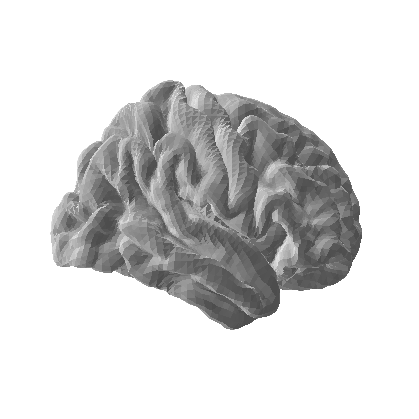

In [11]:
plotting.plot_surf(fsaverage_rh,hemi='right')

Notive how the sulci and gyri of the the fsnative and fsaverage brain are so different. Think of fsaverage as the projection of MNI into surface space. I refer using this form of visualization when we talk about functional date because it ensure you know exactly where on the cortical surface activation of interest is occuring. The interactive plots with surface space are alo a lot easier to view.

In [13]:
plotting.view_surf(surf_mesh=fsaverage_lh,colorbar=False)

# Analysis time
Okay, now lets look at how you can load in and work with your own data when you have multiple runs of the experiment in the same participant.

In [3]:
#load in
image_paths = glob.glob(f'{base_dir}fmriprep/{sub}/{ses}/func/{sub}_{ses}_task-{task}_run-*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
json_paths = glob.glob(f'{base_dir}fmriprep/{sub}/{ses}/func/{sub}_{ses}_task-{task}_run-*_space-MNI152NLin2009cAsym_desc-preproc_bold.json')
events_paths = glob.glob(f'{base_dir}events_csv/{sub}/{sub}_{ses}_task-{task}_run-*_events.csv')

image_paths.sort()
json_paths.sort()
events_paths.sort()

# read in and create a list of all the functional data
images = []
for img in image_paths:
    func_img = nib.load(img)
    images.append(func_img)

**Don't forget to edit your events file so it lines up with the scan data**
Remember that the most crucial part in analyizing functional data is ensuring that you have the correct record of the timing of events in the functional scan. If this is off, your entire analysis will be inaccurate. Make sure to adapt the following code chunk to ensure it matches the variables in your experiment (if you named your intial blank block "Blank" and your expermetnt block as "Trials" then this should work for you. Otherwise make sure to use the correct names).

Calculating an "onset" column in important because PsychoPy starts it's internal timer when you launch the experiement but we don't start the scanner when we launch the experiment. We need to calculate the experiment start time that actually lines up with the start of the scan.

In [6]:
# read in and create a list of all the events files (PsychoPy output)
events_dfs = []

# if you named your conditions as numbers when setting up PsychoPy, it's bester to rename then to a string
conditionNumber_to_conditionName = {
    1.0: 'arithmetic',
    2.0: 'polynomials',
    3.0: 'calculus',
    4.0: 'blank',
}

# read in events csv and edit necessary columns
for csv in events_paths:
    #read in the csv
    events = pd.read_csv(csv)
    # grab scan start time from start of intial 10 second blank trial
    scan_start_time = np.nanmin(np.unique(events['Blank.started']))
    # drop rows that aren't part of the actual task
    events.dropna(subset=['Trials.started'], inplace=True)
    # create an "onset" column that is euqivalent to 'Trials.started' - scan_start_time --- nilearn function looks for onset
    events['onset'] = events['Trials.started'] - scan_start_time
    # create a "duration" column --- nilearn function looks for duration
    events['duration'] = events['Trials.stopped'] - events['Trials.started']
    # create "trial_type" column from "condition" --- nilearn function looks for trial_type
    events['trial_type'] = events['condition'].map(conditionNumber_to_conditionName)
    # remove "blank" condition - the glm assumes all non-labeled time is blank
    events = events.query('trial_type != "blank"')
    events_dfs.append(events)


In [8]:
# check the tr for the experriment - should be 1.19 for all the runs
for file in json_paths:
    t_r = json.load(open(file))['RepetitionTime']
    print(t_r)

1.19
1.19
1.19
1.19


/Users/jamiel12/miniconda3/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: thisTrialN, text.started, frameRate, image_2.started, image.started, key_resp.started, thisN, Trial_Loop.thisRepN, Trial_Loop.thisTrialN, key_resp_2.started, instruction_2.stopped, Trial_Loop.key_resp.duration, participant, Path_Names2, thisRepN, thisRow.t, psychopyVersion, key_resp.duration, Trial_Loop.thisN, key_resp.keys, Trial_Loop.thisIndex, session, notes, key_resp_2.keys, key_resp.rt, Blank.started, condition, key_resp_2.rt, key_resp.stopped, date, Trials.stopped, expStart, Trial_Loop.key_resp.keys, Trial_Loop.key_resp.rt, key_resp_2.duration, image.stopped, Blank.stopped, Trials.started, Unnamed: 40, instruction_2.started, expName
  warnings.warn(
/Users/jamiel12/miniconda3/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected 

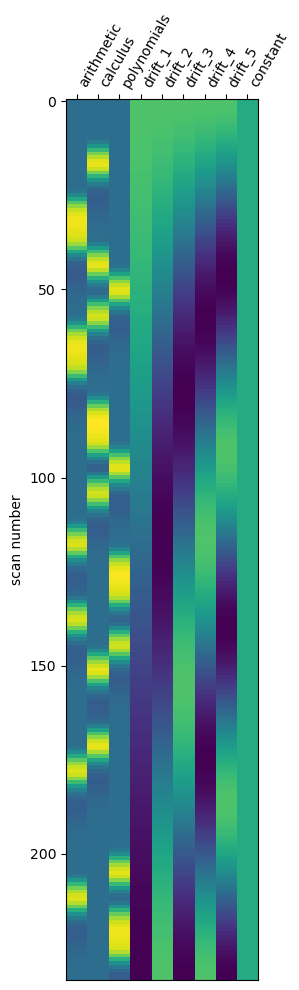

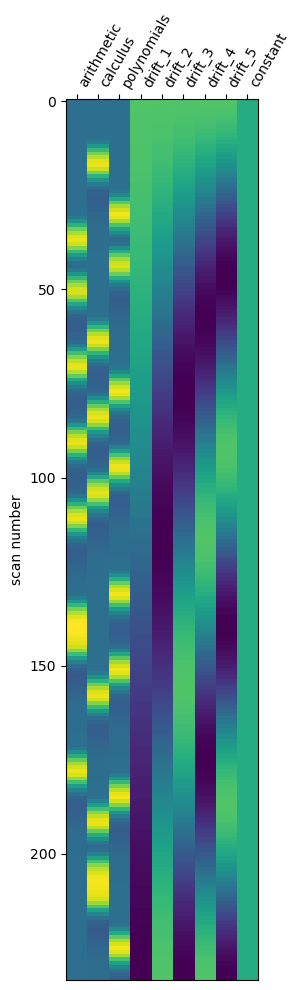

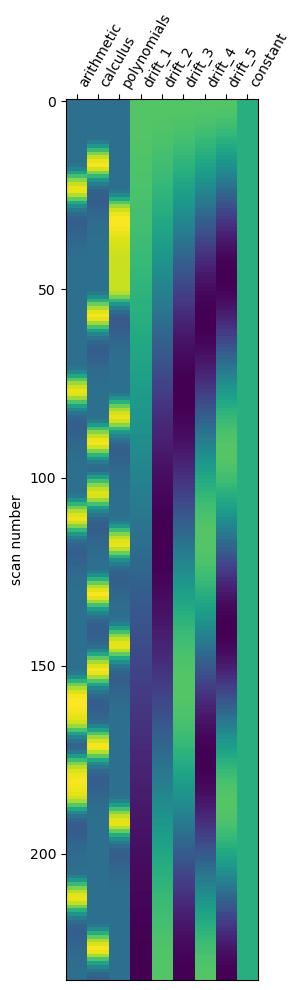

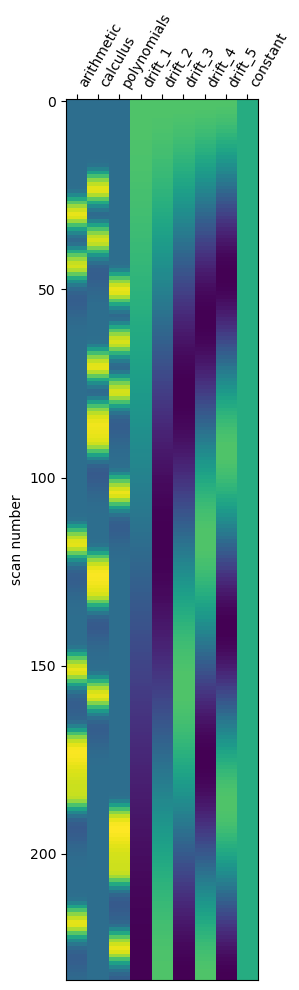

In [9]:
# Fit first level model with no HRF -- set signal_scaling to False so predictions are on same scale as observed
first_level_model = FirstLevelModel(t_r,hrf_model='SPM')

first_level_model_fit = first_level_model.fit(images, events=events_dfs)

# Grab the desing matrix and plot
for dmx in first_level_model_fit.design_matrices_:
    plot_design_matrix(dmx)
    
    plt.show()

<Axes: label='conditions'>

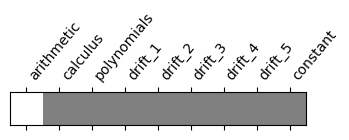

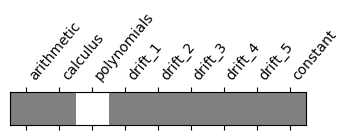

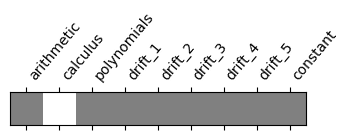

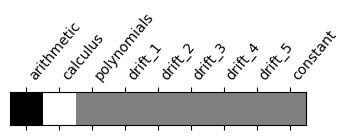

In [10]:
# specify your contrasts
# grab a design matrix to specify order of conditions in contrast
design_matrix = first_level_model_fit.design_matrices_[0]

# create a simple contrast for each column of the design matrix
contrast_matrix = np.eye(design_matrix.shape[1])
contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(design_matrix.columns)
}

#specify the contrasts of interest
contrasts = {
    "arithmetic-blank": (
        contrasts["arithmetic"]
    ),
    "polynomials-blank": (
        contrasts["polynomials"]
    ),
    "calculus-blank": (
        contrasts["calculus"]
    ),
    "calculus-arithmetic": (
        contrasts["calculus"]
        - contrasts["arithmetic"]
    ),
}

# plot contrasts
plot_contrast_matrix(contrasts["arithmetic-blank"], design_matrix)
plot_contrast_matrix(contrasts["polynomials-blank"], design_matrix)
plot_contrast_matrix(contrasts["calculus-blank"], design_matrix)
plot_contrast_matrix(contrasts["calculus-arithmetic"], design_matrix)

In [11]:
# compute contrasts
stat_maps=[]
for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
    stat_map = first_level_model_fit.compute_contrast(
        contrast_val, stat_type = 't', output_type= 'stat',)
    stat_maps.append(stat_map)
    

/var/folders/f5/g8b3dxhx5qv0vfsrypzkw3600000gq/T/ipykernel_43956/1260532015.py:4: UserWarning: One contrast given, assuming it for all 4 runs
  stat_map = first_level_model_fit.compute_contrast(


(<Figure size 426.667x480 with 5 Axes>,
 [<Axes3D: >, <Axes3D: >, <Axes3D: >, <Axes3D: >, <Axes: >])

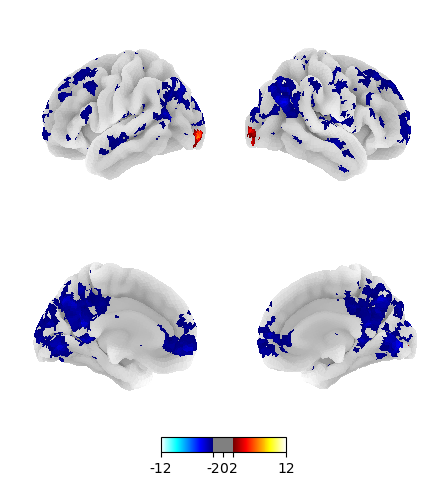

In [21]:
#plot the statistical contrast map on the surface
plotting.plot_img_on_surf(stat_map=stat_maps[0],surf_mesh='fsaverage5',threshold=2)

In [22]:
#plot the statistical contrast map on the surface in an interactive viewer
plotting.view_img_on_surf(stat_map_img=stat_maps[0],surf_mesh='fsaverage5',threshold=2.0)

# Work in progress

From here on out the tutorial is still a work in progress. I havn't had time to finishi it but this first step below is an example of hot to load in anatomical labels from an atlas if you're interesed in doing a region of interst (ROI) analysis. Feel free to play around with this.

In [23]:
# grab the atlas
destrieux_atlas = datasets.fetch_atlas_surf_destrieux()

In [24]:
# choose your label(s)
labels = destrieux_atlas['labels']
roi_index = labels.index(b'S_intrapariet_and_P_trans')

#map label to the surface
roi_map_left = destrieux_atlas['map_left']
roi_map_right = destrieux_atlas['map_right']

# grab the indices of the label (use these indices to mask your statistical maps or glm estimate maps)
roi_indices_left = (np.where(roi_map_left==roi_index))[0]
roi_indices_right = (np.where(roi_map_right==roi_index))[0]